In [1]:
import numpy as np
import matplotlib.pyplot as plt

import GPy
from GPy.kern import Kern
from GPy import Param, Model
from deepRBF import deepRBF
#from MFRBF import MFRBF

In [2]:
from MFRBF import *

In [3]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def compute_nll(y, mf, vf):
    y = y.reshape((y.shape[0],))
    ll = -0.5 * np.log(2 * np.pi * vf) - 0.5 * (y - mf)**2 / vf
    nll = -ll
    return np.mean(nll)

In [4]:
def predict_eff(CovMtx, Y):
    K_ee = CovMtx[1:,1:]
    K_e = CovMtx[0,1:]
    K_inv = np.linalg.inv(K_ee+0.0001*np.eye(K_ee.shape[0]))
    pred_mu = np.matmul(np.matmul(K_e, K_inv), Y)
    pred_v = CovMtx[0,0] - np.matmul(np.matmul(K_e, K_inv), np.matrix.transpose(K_e))
    return pred_mu, np.sqrt(pred_v)


In [5]:
def f_low(x):
    return np.sin(8*np.pi*x)

def f_high(x):
    return (x-np.sqrt(2)) * (f_low(x))**2

num_cheap = 30
num_expensive = 10

np.random.seed(59)
X1 = np.random.rand(num_cheap)[:,None]
#X2 = np.linspace(0,1,num_expensive)[:,None]
X2 = np.random.rand(num_expensive)[:,None]
Yc = f_low(X1)

Ye = f_high(X2) + 0.001 * np.random.normal(0,1,num_expensive)[:,None]

Optimization restart 1/10, f = -95.70308161125749
Optimization restart 2/10, f = 32.005720973696064
Optimization restart 3/10, f = 32.00571564678128
Optimization restart 4/10, f = -95.70308283621421
Optimization restart 5/10, f = 32.00572419112443
Optimization restart 6/10, f = 32.00571614799965
Optimization restart 7/10, f = 32.005723517149406
Optimization restart 8/10, f = 32.00571565276674
Optimization restart 9/10, f = -95.70307299014806
Optimization restart 10/10, f = 32.00571597442917


{'dataplot': [<matplotlib.collections.PathCollection at 0x7fba62fbb9e8>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7fba62fbba20>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7fba62fbbe48>]}

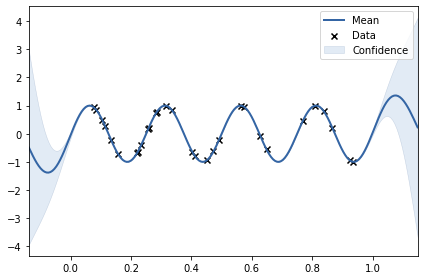

In [6]:
K1 = GPy.kern.RBF(input_dim = 1, variance = 1, lengthscale = 0.1)
m1 = GPy.models.GPRegression(X1, Yc, K1, noise_var = 0.0001)
m1.optimize(messages=True)
m1.optimize_restarts(num_restarts = 10)
m1.plot()

In [7]:
mu, v = m1.predict(X2, full_cov = True)

deepKern = MFRBF(input_dim=1, variance = 0.8, lengthscale = 0.2, mu = mu, v=v)
kRBF = GPy.kern.RBF(input_dim = 1)

effKern = kRBF * deepKern

In [8]:
m2 = GPy.models.GPRegression(X2, Ye, effKern)
m2.optimize()

In [9]:
m2.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = -17.028270345722053
Optimization restart 2/10, f = -17.028270343824275
Optimization restart 3/10, f = -17.028270345232244
Optimization restart 4/10, f = -17.028270345258854
Optimization restart 5/10, f = -17.028270343764067
Optimization restart 6/10, f = -17.02827034508928
Optimization restart 7/10, f = -17.028270342500054
Optimization restart 8/10, f = -17.028270342484767
Optimization restart 9/10, f = 0.007857352249159177
Optimization restart 10/10, f = -17.02827034433221


In [10]:
print(m2)


Name : GP regression
Objective : -17.028270345722053
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  mul.rbf.variance         |     0.47041616264905595  |      +ve      |        
  mul.rbf.lengthscale      |       2.760265377996914  |      +ve      |        
  mul.MFRBF.variance       |       5.154697413094251  |               |        
  mul.MFRBF.lengtscale     |       2.292849000224166  |               |        
  Gaussian_noise.variance  |  1.6945384190664512e-06  |      +ve      |        


In [11]:
print(m2.kern.rbf.variance[0])
print(m2.kern.rbf.lengthscale[0])
print(m2.kern.MFRBF.variance[0])
print(m2.kern.MFRBF.lengthscale[0])

0.47041616264905595
2.760265377996914
5.154697413094251
2.292849000224166


In [12]:
#s1=0.8817598540664018 
#l1=1.0049914242449915
#s2=0.41618880973211025
#l2=0.740372462046252 

s1 = m2.kern.rbf.variance[0]
l1 = m2.kern.rbf.lengthscale[0]
s2 = m2.kern.MFRBF.variance[0]
l2 = m2.kern.MFRBF.lengthscale[0]

X_test = np.linspace(0,1,99)[:,None]
Y_test=[]
Y_test_up=[]
Y_test_down=[]

for xx in X_test:
    Xnew = np.vstack((xx,X2))
    mu1, v1 = m1.predict(Xnew, full_cov = True)
    kernMF = MFRBF(input_dim=1,variance = s2, lengthscale = l2, mu = mu1, v=v1)
    kernRBF = GPy.kern.RBF(input_dim = 1, variance = s1, lengthscale = l1)
    M1 = kernMF.K(Xnew)
    M2 = kernRBF.K(Xnew)
    GG = np.multiply(M1, M2)
    
    pred_mu, pred_v = predict_eff(GG, Ye)
    
    Y_test.append(pred_mu)
    Y_test_up.append(pred_mu+1.96*pred_v)
    Y_test_down.append(pred_mu-1.96*pred_v)

In [13]:
X_plot = np.linspace(0,1,200)[:,None]
f_c=f_low(X_plot)
f_e=f_high(X_plot)

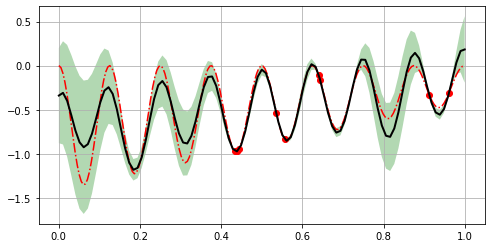

In [54]:
fig, ax = plt.subplots(figsize=(8,4))
plt.plot(X2,Ye,'ro')
plt.plot(X_plot,f_e,'r-.')
#plt.plot(X_plot,f_c,'b.')
plt.plot(X_test,Y_test,'k-',linewidth=2)
plt.fill_between(np.array(X_test).flatten(),np.array(Y_test_up).flatten(),np.array(Y_test_down).flatten(),facecolor='g',alpha=0.3)
plt.grid()
plt.show()

In [15]:
fig.savefig('nonlinearA.pdf', bbox_inches='tight')

{'dataplot': [<matplotlib.collections.PathCollection at 0x7fba66f519e8>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7fba66f51a20>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7fba66f51e80>]}

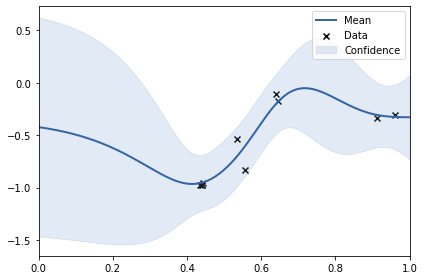

In [48]:
d_rbf = deepRBF(input_dim=X2.shape[1])
m3 = GPy.models.GPRegression(X2, Ye,d_rbf)
m3.optimize()
#m3.optimize_restarts(num_restarts = 10)
m3.plot([0,1])

In [61]:
print(m3)


Name : GP regression
Objective : 0.06907062326981261
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  deep_rbf.variance1       |   1.1812531287955157  |               |        
  deep_rbf.lengtscale      |  0.23648903984694367  |               |        
  deep_rbf.variance2       |    0.457010820982359  |               |        
  Gaussian_noise.variance  |  0.01489401750394943  |      +ve      |        


Optimization restart 1/10, f = 0.007856378911248463
Optimization restart 2/10, f = 0.007856378912705075
Optimization restart 3/10, f = 0.007856378913236206
Optimization restart 4/10, f = 0.007856378911141881
Optimization restart 5/10, f = 0.007856378911117012
Optimization restart 6/10, f = 0.007856378913114526
Optimization restart 7/10, f = -6.357190140286285
Optimization restart 8/10, f = 0.007856378912866724
Optimization restart 9/10, f = 0.007856378911656137
Optimization restart 10/10, f = 0.007856378911864859


{'dataplot': [<matplotlib.collections.PathCollection at 0x7fba66e07a20>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7fba66e07a58>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7fba66e07eb8>]}

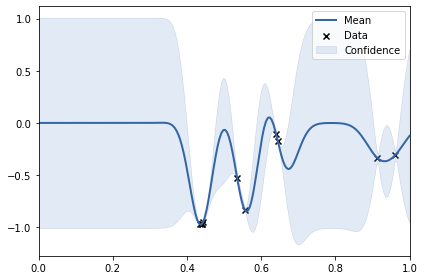

In [47]:
m4 = GPy.models.GPRegression(X2, Ye)
m4.optimize()
m4.optimize_restarts(num_restarts = 10)
m4.plot([0,1])

In [62]:
print(m4)


Name : GP regression
Objective : -6.357190140286285
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  rbf.variance             |    0.26412869195629146  |      +ve      |        
  rbf.lengthscale          |    0.03403058664361037  |      +ve      |        
  Gaussian_noise.variance  |  2.789876287079397e-06  |      +ve      |        


In [30]:
period_kernel = GPy.kern.PeriodicExponential(1)

In [38]:
m5 = GPy.models.GPRegression(X2, Ye, kernel = period_kernel)

Optimization restart 1/10, f = -6.627088314256762
Optimization restart 2/10, f = -6.601128764653815
Optimization restart 3/10, f = -0.1033188442442059
Optimization restart 4/10, f = -0.4149209408651071
Optimization restart 5/10, f = -0.10331884424212401


 /Users/felix/anaconda3/lib/python3.6/site-packages/GPy/kern/src/periodic.py:86: RuntimeWarning:overflow encountered in true_divide
 /Users/felix/anaconda3/lib/python3.6/site-packages/GPy/kern/src/periodic.py:40: RuntimeWarning:invalid value encountered in multiply
 /Users/felix/anaconda3/lib/python3.6/site-packages/GPy/kern/src/periodic.py:40: RuntimeWarning:invalid value encountered in cos


Optimization restart 6/10, f = -0.10331884422948523
Optimization restart 7/10, f = 0.7611763646185725
Optimization restart 8/10, f = -0.10331884424110438
Optimization restart 9/10, f = -0.11434241793150424
Optimization restart 10/10, f = -0.028077061528758662


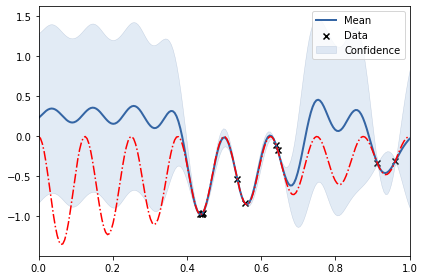

In [55]:
m5.optimize()
m5.optimize_restarts(num_restarts = 10)
m5.plot([0,1])
plt.plot(X_plot,f_e,'r-.')

In [40]:
print(m5)


Name : GP regression
Objective : -6.487134694843324
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.                    |                   value  |  constraints  |  priors
  periodic_exponential.variance     |       5.233234739826042  |      +ve      |        
  periodic_exponential.lengthscale  |    0.038156264048158715  |      +ve      |        
  periodic_exponential.period       |      1.0541403279390074  |      +ve      |        
  Gaussian_noise.variance           |  2.5867847210658775e-06  |      +ve      |        


In [57]:
# using periodic kernel
m5.log_likelihood()

6.627088314256762

In [58]:
# using SE kernel
m4.log_likelihood()

6.357190140286285

In [59]:
# using deepSE kernel
m3.log_likelihood()

-0.06907062326981261

In [60]:
# using MF-deepSE kernel
m2.log_likelihood()

17.028270345722053